In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

#Batched compression and pruning

class SVDDense(keras.layers.Layer):
    
    def __init__(self, units=32, mu_ort = 1000, mu_sing = 1, mu_comp = 0.1, prune_threshold = 0.1  , pruning_batch_size = 1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.mu_ort = mu_ort
        self.mu_sing = mu_sing
        self.mu_comp = mu_comp
        self.prune_threshold = prune_threshold
        self.rank = 1 #Is replaced later.
        self.pruning_batch_size = pruning_batch_size

    def build(self, input_shape):

        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)

        values = initializer(shape=(input_shape[-1], self.units))

        #It is not possible to directly set weights on creation, so for now we're generating them as zeros and calling assign
        sigma, u, v = tf.linalg.svd(values, full_matrices=False)
        vt = tf.transpose(v)
        self.rank = int(tf.shape(sigma)[0])
        print(self.rank)

        
        self.u = self.add_weight(
            shape=(input_shape[-1], self.rank), initializer='zeros', trainable=True, name="u"
        )
        self.u.assign(u)

        self.sigma = self.add_weight(
            shape=(self.rank,), initializer='zeros', trainable=True, name="sigma"
        )
        self.sigma.assign(sigma)

        self.vt = self.add_weight(
            shape=(self.rank, self.units), initializer='zeros', trainable=True, name="vt"
        )
        self.vt.assign(vt)

        self.b = self.add_weight(
            shape=(self.units,), initializer=initializer, trainable=True, name="bias"
        )

        self.rank = tf.Variable(self.rank, trainable=False, dtype=tf.int32)


    def call(self, inputs):

        current_u = self.u[:, :self.rank]
        current_sigma = self.sigma[:self.rank]
        current_vt = self.vt[:self.rank]
        #rank_f = tf.cast(self.rank, tf.float32)

        
        smallest_batch = tf.reduce_sum(current_sigma[-self.pruning_batch_size:])
        secondSmallest_batch = tf.reduce_sum(current_sigma[-self.pruning_batch_size*2:-self.pruning_batch_size])

        tf.cond(
            self.rank > self.pruning_batch_size,
            lambda: self.rank.assign(tf.cond(
                smallest_batch < self.prune_threshold * secondSmallest_batch,
                    lambda: self.rank - self.pruning_batch_size,
                    lambda: self.rank
            )),
            lambda: self.rank
        )

#         #can_decrease = current_sigma[-1] < self.prune_threshold * sigma[-2]
#         #sigma_mask = tf.cast(tf.range(tf.shape(self.sigma)[0]) == (self.rank - 1), tf.float32)
#         rank_int = tf.cast(self.rank, tf.int32)
#         last_sigma = tf.gather(self.sigma, rank_int - 1)#self.sigma[-1]
        
        #Calculate loss for this layer
        self.add_loss(
            #normality loss
            self.mu_ort * (
                tf.reduce_mean(tf.abs(1-tf.reduce_sum(tf.square(current_vt), axis=0))) + 
                tf.reduce_mean(tf.abs(1-tf.reduce_sum(tf.square(current_u), axis=1)))
            )
                #tf.reduce_mean(tf.square(tf.matmul(current_u, current_u, transpose_a=True) - tf.eye(tf.shape(current_sigma)[0]))) + 
                #tf.reduce_mean(tf.square(tf.matmul(current_vt, current_vt, transpose_b=True) - tf.eye(tf.shape(current_sigma)[0])))
            +

            #sorting loss
            self.mu_sing * (
                self.singular_sorting_loss(current_sigma)
            )

            +

            # Compression loss 
            # Different from the original paper, it simply attempts to further decrease the size of the final (smallest) singular value.
            self.mu_comp * smallest_batch        
        )
        
        x = tf.matmul(inputs, current_u)
        x = tf.matmul(x, tf.linalg.diag(current_sigma))
        x = tf.matmul(x, current_vt)
        return x + self.b
    
    def singular_sorting_loss(self, weights):
        difs = weights[1:] - weights[:-1] #The differences of each value and the one after
        difsum = tf.math.divide_no_nan(tf.reduce_sum(tf.nn.relu(-difs)), #Sum of negative differences
                                       tf.reduce_sum(tf.cast(difs < 0, tf.float32))) #divided by the amount of negative differences (with 0 if dividing by 0)
        # sumnegs = tf.math.divide_no_nan(tf.reduce_sum(tf.nn.relu(-weights)),  #Sum of negative weights
        #                                 tf.reduce_sum(tf.cast(weights < 0, tf.float32))) #divided by the amount of negative weights (with 0 if dividing by 0)
        negs = tf.nn.relu(-weights[-1]) #And a push to keep the final value above 0. 
        return difsum + negs

#Can be created using a finished SVDDense layer. Used to actually decrease the parameter count, and does not prune or compress anymore. 
class RecomposedDense(keras.layers.Layer):
    def __init__(self, units=32, weights = [], b = [], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.w = weights
        self.b = b

    def build(self, input_shape):

        self.w = self.add_weight(
            shape=(input_shape[-1], self.units), initializer=tf.constant_initializer(self.w), trainable=True, name="weights"
        )
        
        self.b = self.add_weight(
            shape=(self.units,), initializer=tf.constant_initializer(self.b), trainable=True, name="bias"
        )
        
    def call(self, inputs):

        #Temp test, try to immediately prune everything but 1
        # tf.cond(self.rank > 1, lambda: self.rank.assign_sub(1), lambda: self.rank)

        #Calculate loss for this layer
#        self.add_loss(0)
        x = tf.matmul(inputs, self.w)
        return x + self.b
    
class DecomposedDense(keras.layers.Layer):
    def __init__(self, units=32, u_sigma = [], vt = [], b = [], *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.rank = 1 #Overwritten during build.
        self.u_sigma = u_sigma
        self.vt = vt
        self.b = b

    def build(self, input_shape):
        
        self.rank = int(tf.shape(self.u_sigma)[1])

        self.u_sigma = self.add_weight(
            shape=(input_shape[-1], self.rank), initializer=tf.constant_initializer(self.u_sigma), trainable=True, name="u"
        )

        if len(self.vt) == 1:
           self.vt = self.vt[0][0]

        self.vt = self.add_weight(
            shape=(self.rank, self.units), initializer=tf.constant_initializer(self.vt), trainable=True, name="vt"
            #shape=(int(self.rank), self.units), initializer='zeros', trainable=True, name="vt"
        )
        #self.vt.assign(vt)

        self.b = self.add_weight(
            shape=(self.units,), initializer=tf.constant_initializer(self.b), trainable=True, name="bias"
        )

        self.rank = tf.Variable(self.rank, trainable=False, dtype=tf.int32)

        
    def call(self, inputs):

        #Temp test, try to immediately prune everything but 1
        # tf.cond(self.rank > 1, lambda: self.rank.assign_sub(1), lambda: self.rank)

        #Calculate loss for this layer
#        self.add_loss(0)
        x = tf.matmul(inputs, self.u_sigma)
        x = tf.matmul(x, self.vt)
        return x + self.b

2025-06-27 10:25:18.404158: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 10:25:18.443382: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 10:25:18.443407: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 10:25:18.443449: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-27 10:25:18.452126: I tensorflow/core/platform/cpu_feature_g

In [2]:
import numpy as np
import tensorflow as tf
import CustomModel
import CustomMetrics
from tensorflow import keras
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x = x_train
y = y_train

y = keras.utils.to_categorical(y, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)


# Construct an instance of CustomModel
inputs = keras.Input(shape=(np.shape(x)[-2], np.shape(x)[-1]))
flattened = keras.layers.Flatten()(inputs)
outputs = SVDDense(
    units = 600,
    mu_comp = 0,
    prune_threshold = 0.5,
    pruning_batch_size = 15,
    mu_ort = 2,
    mu_sing = 1,
    name = "first"
)(flattened)
outputs = keras.layers.Activation('relu')(outputs)
outputs = SVDDense(
    units = 300,
    mu_comp = 0,
    prune_threshold = 0.2,
    pruning_batch_size = 6,
    mu_ort = 2,
    mu_sing = 1,
    name = "second"
)(outputs)
outputs = keras.layers.Activation('relu')(outputs)
outputs = keras.layers.Dense(
    units = 10,
)(outputs)
outputs = keras.layers.Activation('softmax')(outputs)
model = CustomMetrics.CustomModel(inputs, outputs)

# We don't pass a loss or metrics here.
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=6e-3, momentum=0.4, clipnorm=4.0))

# Just use `fit` as usual -- you can use callbacks, etc.
model.summary()
firstFit = model.fit(x, y, epochs=150, batch_size=1000, validation_data=(x_test, y_test))

#Recompile the model to only use the pruned version.
outputs = flattened
input_size = np.shape(x)[-1]
for layerIndex in range(2, len(model.layers)-2):
    layer = model.layers[layerIndex]

    if isinstance(layer, SVDDense):  
        if (layer.input_shape[-1] * layer.units) > (int(layer.rank) * (layer.input_shape[-1] + layer.units)):
            weights = layer.get_weights()
            outputs = DecomposedDense(
                units = layer.units,
                u_sigma = np.matmul(weights[0][:, :int(layer.rank)], np.diag(weights[1][:int(layer.rank)])),
                vt = weights[2][:int(layer.rank)],
                b = weights[3]
            )(outputs)
            print('Kept decomposed layer', layerIndex, 'with rank: ', layer.rank)
            print(layer.sigma[:layer.rank])
        else:
            weights = layer.get_weights()
            outputs = RecomposedDense(
                units = layer.units,
                weights = np.matmul(np.matmul(weights[0][:, :int(layer.rank)], np.diag(weights[1][:int(layer.rank)])), weights[2][:int(layer.rank)]),
                b = weights[3]
            )(outputs)
            print(layerIndex, 'was too complex and was recomposed. It had rank', layer.rank)
    else: #if isinstance(layer, keras.activations) :
        new_layer = layer.__class__.from_config(layer.get_config())
        outputs = new_layer(outputs)
        
layer = model.layers[len(model.layers)-2]
weights = layer.get_weights()
outputs = RecomposedDense(
    units = layer.units,
    weights = weights[0],
    b = weights[1]
    )(outputs)
outputs = keras.layers.Activation('softmax')(outputs)


newModel = CustomModel.CustomModel(inputs, outputs)
newModel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=8e-4, momentum=0.6, clipnorm=2.0))
newModel.summary()
newModel.fit(x, y, epochs=10, batch_size=1000, validation_data=(x_test, y_test))


2025-06-27 10:25:53.247882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1188 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:1b:00.0, compute capability: 8.6
2025-06-27 10:25:53.250904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13285 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:1c:00.0, compute capability: 8.6
2025-06-27 10:25:53.253293: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13285 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:1d:00.0, compute capability: 8.6
2025-06-27 10:25:53.255859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13285 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:1e:00.0, compute capability: 8.6
2

600


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


300
Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 first (SVDDense)            (None, 600)               831601    
                                                                 
 activation (Activation)     (None, 600)               0         
                                                                 
 second (SVDDense)           (None, 300)               270601    
                                                                 
 activation_1 (Activation)   (None, 300)               0         
                                                                 
 dense (Dense)               (None, 10)           

2025-06-27 10:25:56.993840: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f28daf14f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-27 10:25:56.993866: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2025-06-27 10:25:56.993870: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A16, Compute Capability 8.6
2025-06-27 10:25:56.993873: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A16, Compute Capability 8.6
2025-06-27 10:25:56.993876: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A16, Compute Capability 8.6
2025-06-27 10:25:56.993879: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (4): NVIDIA A16, Compute Capability 8.6
2025-06-27 10:25:56.993882: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor de

60/60 [==============================] - 4s 23ms/step - loss: 23.0936 - cce: 50.1835 - acc: 0.8377 - rank_1: 600.0000 - rank_2: 300.0000 - val_cce: 6.5250 - val_acc: 0.8894
Epoch 2/150
60/60 [==============================] - 1s 20ms/step - loss: 5.5501 - cce: 4.5089 - acc: 0.8762 - rank_1: 600.0000 - rank_2: 300.0000 - val_cce: 2.9483 - val_acc: 0.8657
Epoch 3/150
60/60 [==============================] - 1s 20ms/step - loss: 3.6570 - cce: 2.1534 - acc: 0.8606 - rank_1: 600.0000 - rank_2: 300.0000 - val_cce: 2.1572 - val_acc: 0.8487
Epoch 4/150
60/60 [==============================] - 1s 20ms/step - loss: 2.8514 - cce: 1.1921 - acc: 0.8536 - rank_1: 600.0000 - rank_2: 300.0000 - val_cce: 1.6078 - val_acc: 0.8625
Epoch 5/150
60/60 [==============================] - 1s 19ms/step - loss: 2.3963 - cce: 0.7129 - acc: 0.8477 - rank_1: 600.0000 - rank_2: 300.0000 - val_cce: 1.3800 - val_acc: 0.8408
Epoch 6/150
60/60 [==============================] - 1s 20ms/step - loss: 2.1586 - cce: 0.4644 

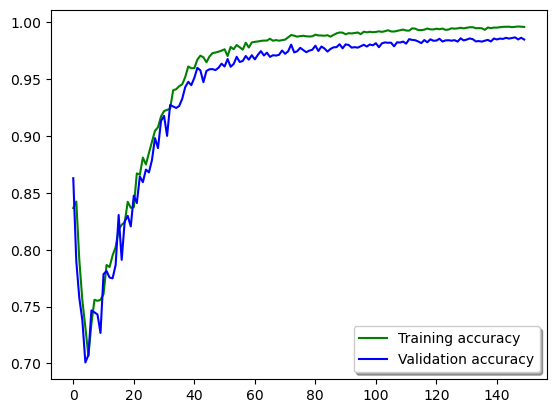

In [6]:
    
fig, ax1 = plt.subplots(1,1)

ax1.plot(firstFit.history['acc'], color='g', label="Training accuracy")
ax1.plot(firstFit.history['val_acc'], color='b', label="Validation accuracy")

#ax[0].plot(firstFit.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
ax1.legend(loc=4, bbox_to_anchor=(0, 0, 1, 1), shadow=True)
ax2.legend(loc=4, bbox_to_anchor=(-0.39, 0, 1, 1), shadow=True)